# Black Friday EDA + Prediction

### Importing Resources

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score 
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

### Loading Data

In [9]:
#pd.set_option('display.max_columns',20)
df=pd.read_csv('BlackFriday.csv');
df=pd.get_dummies(df, columns=['City_Category'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 14 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
City_Category_A               537577 non-null uint8
City_Category_B               537577 non-null uint8
City_Category_C               537577 non-null uint8
dtypes: float64(2), int64(5), object(4), uint8(3)
memory usage: 46.7+ MB
None


### Printing the Unique Values in each column

In [10]:
for col in df:
    print(col)
    print(df[col].unique())

User_ID
[1000001 1000002 1000003 ... 1004113 1005391 1001529]
Product_ID
['P00069042' 'P00248942' 'P00087842' ... 'P00038842' 'P00295642'
 'P00091742']
Gender
['F' 'M']
Age
['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Occupation
[10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
Stay_In_Current_City_Years
['2' '4+' '3' '1' '0']
Marital_Status
[0 1]
Product_Category_1
[ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9]
Product_Category_2
[nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Product_Category_3
[nan 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]
Purchase
[ 8370 15200  1422 ... 14539 11120 18426]
City_Category_A
[1 0]
City_Category_B
[0 1]
City_Category_C
[0 1]


### Grouping by Columns

In [50]:
group = df.groupby(['Age','Marital_Status','Gender'])
df2 = group.apply(lambda x: x['Purchase'].mean())
print(df2)

Age  Marital_Status  Gender
0    0               0         8444.703210
                     1         9312.322227
1    0               0         8545.439130
                     1         9504.405094
     1               0         7994.813144
                     1         9515.023134
2    0               0         8658.499711
                     1         9503.760597
     1               0         8988.077158
                     1         9418.421636
3    0               0         9101.034284
                     1         9594.000657
     1               0         8958.785566
                     1         9401.579865
4    0               0         8863.455051
                     1         9091.796398
     1               0         8950.054506
                     1         9568.826271
5    0               0         9240.929966
                     1         9869.571908
     1               0         9069.432033
                     1         9761.350137
6    0               0    

### Filling Missing Values and Encoding Categorical Columns

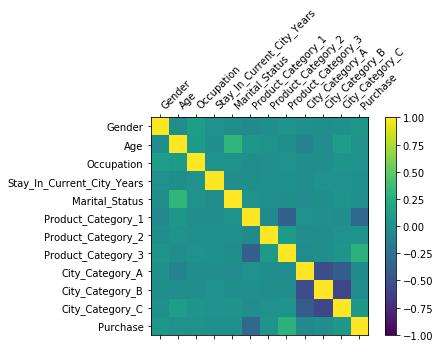

In [12]:
df['Product_Category_2'].fillna(0, inplace=True)
df['Product_Category_3'].fillna(0, inplace=True)
df['Stay_In_Current_City_Years']=df['Stay_In_Current_City_Years'].astype('category').cat.codes
df['Age']=df['Age'].astype('category').cat.codes
df['Gender']=df['Gender'].astype('category').cat.codes
df['Purchase']=df['Purchase'].astype('float64')
#cols_at_end = ['Purchase','Product_Category_1','Product_Category_2','Product_Category_3']
cols_at_end = ['Purchase']
df = df[[c for c in df if c not in cols_at_end] + [c for c in cols_at_end if c in df]]
new=df.iloc[:,2:15]
correlations = new.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(new.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(new.columns.values)
ax.set_yticklabels(new.columns.values)
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='left')
plt.show()

### Splitting Data into Train and Test and Applying Standard Scaler and PCA

In [13]:
X_train, X_test, y_train, y_test = train_test_split(new.iloc[:,0:11],new.iloc[:,11:], test_size=0.2)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)
pca=PCA(0.95)
fit=pca.fit_transform(X_train)
X_train=pd.DataFrame(data=fit)
X_test=pca.transform(X_test)
X_test=pd.DataFrame(data=X_test)
cols=[]
for i in range(len(X_train.columns)):
    cols.append("PC"+str(i));
X_train.columns=cols
X_test.columns=cols

### Predicting Purchase made by a Customer using Lasso Model

R2 score: 0.14
RMS: 4623.88


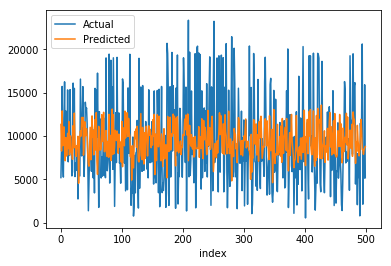

In [47]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train,y_train)
y_predicted=clf.predict(X_test)
print('R2 score: %.2f' % r2_score(y_test, y_predicted))
print("RMS: %.2f" % sqrt(mean_squared_error(y_test, y_predicted)))
arg=pd.DataFrame(data=y_test.values)
h=pd.Series(y_predicted)
arg = pd.concat([arg,h], axis = 1)
arg.columns=['Actual','Predicted']
arg=arg.reset_index()
arg=arg[:500]
arg.plot(x='index', y=['Actual','Predicted'],kind='line')

### Prediction Using Linear Regression Model

R2 score: 0.14
RMS: 4623.88


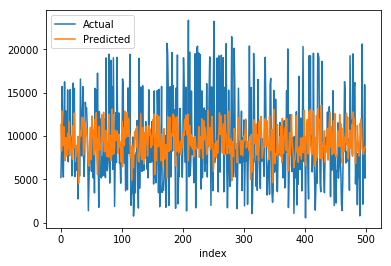

In [48]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
y_predicted = regr.predict(X_test)
print('R2 score: %.2f' % r2_score(y_test, y_predicted))
print("RMS: %.2f" % sqrt(mean_squared_error(y_test, y_predicted)))
arg=pd.DataFrame(data=y_test.values)
h=pd.Series(y_predicted[:,0])
arg = pd.concat([arg,h], axis = 1)
arg.columns=['Actual','Predicted']
arg=arg.reset_index()
arg=arg[:500]
arg.plot(x='index', y=['Actual','Predicted'],kind='line')